In [11]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from netCDF4 import Dataset
import matplotlib as mpl

# make 1.2 and 0.8 times anomaly SST

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

# Paths to the NetCDF files
file_path  = 'sst_HadOIBl_bc_0.9x1.25_clim_c040926.nc'
file_path2 = 'domain.ocn.0.9x1.25_gx1v6_090403.nc'

# Open the NetCDF files
dataset  = nc.Dataset(file_path, mode='r')
dataset2 = nc.Dataset(file_path2, mode='r')

# Access the SST_cpl variable and the land-sea mask
SST_cpl = dataset.variables['SST_cpl'][:]  # Replace 'SST_cpl' with the actual variable name if different
mask = dataset2.variables['mask'][:]       # Read land-sea mask (assumed to be 2D: lat, lon)

# Print dimensions for debugging
print(f"SST_cpl dimensions: {SST_cpl.shape}")
print(f"Mask dimensions: {mask.shape}")

# Assume the dimensions are (time, lat, lon)
time_dim, lat_dim, lon_dim = SST_cpl.shape

# Create an array to store the adjusted SST_cpl
SST_cpl_adjusted = np.empty_like(SST_cpl)

# set n times anomaly SST
n = 0.5
new_file_path = f'sst_HadOIBl_bc_0.9x1.25_clim_c040926_{n}times_anomaly.nc'

# Loop over each time step
for t in range(time_dim):
    # Calculate zonal mean only over ocean points
    zonal_mean = np.sum(SST_cpl[t, :, :] * mask, axis=1, keepdims=True) / np.sum(mask, axis=1, keepdims=True)
    
    # Calculate anomaly only for ocean points
    anomaly = (SST_cpl[t, :, :] - zonal_mean) * mask
    
    # Scale the anomaly for ocean points only
    scaled_anomaly = n * anomaly
    
    # Reconstruct the SST_cpl with adjusted ocean anomalies and unchanged land temperatures
    SST_cpl_adjusted[t, :, :] = scaled_anomaly + zonal_mean

    # Ensure land points retain their original value
    SST_cpl_adjusted[t, :, :] = SST_cpl_adjusted[t, :, :] * mask + SST_cpl[t, :, :] * (1 - mask)

# Create a new NetCDF file to store the adjusted SST_cpl
with nc.Dataset(new_file_path, 'w', format='NETCDF4') as new_dataset:
    # Copy dimensions from the original dataset
    for name, dimension in dataset.dimensions.items():
        new_dataset.createDimension(name, len(dimension) if not dimension.isunlimited() else None)
    
    # Copy all variables except SST_cpl
    for name, variable in dataset.variables.items():
        if name != 'SST_cpl':
            x = new_dataset.createVariable(name, variable.datatype, variable.dimensions)
            new_dataset[name][:] = dataset[name][:]
            # Copy variable attributes
            new_dataset[name].setncatts(dataset[name].__dict__)
    
    # Create the new SST_cpl variable
    SST_cpl_var = new_dataset.createVariable('SST_cpl', dataset.variables['SST_cpl'].datatype, dataset.variables['SST_cpl'].dimensions)
    SST_cpl_var[:] = SST_cpl_adjusted
    # Copy variable attributes
    SST_cpl_var.setncatts(dataset.variables['SST_cpl'].__dict__)

    # Copy global attributes
    new_dataset.setncatts({attr: dataset.getncattr(attr) for attr in dataset.ncattrs()})

# Close the original datasets
dataset.close()
dataset2.close()

SST_cpl dimensions: (12, 192, 288)
Mask dimensions: (192, 288)


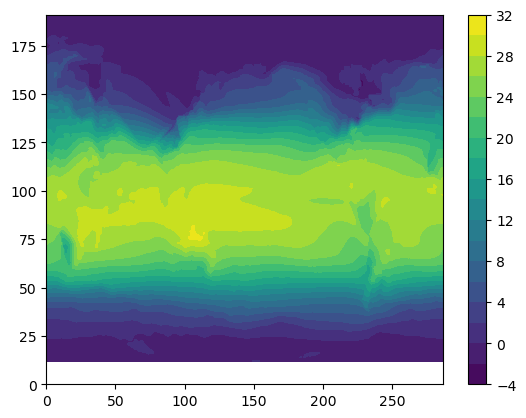

In [166]:
plt.figure()
plt.contourf(SST_cpl_adjusted[0], levels=21)
# plt.contourf(SST_cpl[0], levels=21)
plt.colorbar()

# Calculate RMM index with TaiESM data Jan to June

In [168]:
# Read file
# with Dataset("f09.F2000_0101_0601_daily.nc", "r") as f:
with Dataset("/data92/PeterChang/ESM_2025/f09.F2000_MJO_1.5anomaly.cam.h0.1101_0201.nc", "r") as f:
    
    print(f.variables.keys())
    u850 = f["U850"][:]
    # v850 = f["V850"][:]
    q = f["Q"][:]
    PRECL = f["PRECL"][:]

dict_keys(['time', 'time_bnds', 'slat', 'lat', 'lon', 'lev', 'lev_bnds', 'ilev', 'ilev_bnds', 'date', 'datesec', 'w_stag', 'nlon', 'wnummax', 'gw', 'ndcur', 'nscur', 'co2vmr', 'ch4vmr', 'n2ovmr', 'f11vmr', 'f12vmr', 'sol_tsi', 'nsteph', 'AEROD_v', 'ANRAIN', 'ANSNOW', 'AODDUST1', 'AODDUST3', 'AODVIS', 'AQRAIN', 'AQSNOW', 'AREI', 'AREL', 'AWNC', 'AWNI', 'BURDEN1', 'BURDEN2', 'BURDEN3', 'BURDENBC', 'BURDENDUST', 'BURDENPOM', 'BURDENSEASALT', 'BURDENSO4', 'BURDENSOA', 'CCN3', 'CDNUMC', 'CGH', 'CGS', 'CLDHGH', 'CLDICE', 'CLDLIQ', 'CLDLOW', 'CLDMED', 'CLDTOT', 'CLOUD', 'DCQ', 'DMS_SRF', 'DTCOND', 'DTV', 'EMISCLD', 'FICE', 'FLDS', 'FLNS', 'FLNSC', 'FLNT', 'FLNTC', 'FLUT', 'FLUTC', 'FREQI', 'FREQL', 'FREQR', 'FREQS', 'FSDS', 'FSDSC', 'FSNS', 'FSNSC', 'FSNT', 'FSNTC', 'FSNTOA', 'FSNTOAC', 'FSUTOA', 'H2O2_SRF', 'H2SO4_SRF', 'ICEFRAC', 'ICIMR', 'ICWMR', 'IWC', 'KBFS', 'KHFS', 'KQFS', 'KSCT', 'KSCU', 'KVF', 'KVH', 'KVM', 'LANDFRAC', 'LHFLX', 'LWCF', 'NUMICE', 'NUMLIQ', 'OCNFRAC', 'OMEGA', 'OMEGAT'

In [177]:
# plt.figure()
# # plt.contourf(u850[-1] - u850_control[-1], levels=11)
# plt.contourf(q[-1, -1] - q_control[-1,-1], levels=11)

# plt.colorbar()

In [160]:
# RMM plot
def plot_mjo_phase_space(figsize):
    
    import numpy as np
    from matplotlib import pyplot as plt
    import matplotlib.lines as lines
    
    fig, ax = plt.subplots(1,1,figsize=figsize) 
    
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    ax.set_xticks(range(-4,5))
    ax.set_yticks(range(-4,5))

    # plot mjo phase diagram lines
    line1 = lines.Line2D([np.cos(np.pi/4), 4], [np.sin(np.pi/4), 4], color='black', linestyle='--', lw=1)
    ax.add_line(line1)
        
    line2 = lines.Line2D([np.cos(3*np.pi/4), -4], [np.sin(np.pi/4), 4], color='black', linestyle='--', lw=1)
    ax.add_line(line2)
        
    line3 = lines.Line2D([np.cos(np.pi/4), 4], [np.sin(7*np.pi/4), -4], color='black', linestyle='--', lw=1)
    ax.add_line(line3)
        
    line4 = lines.Line2D([np.cos(3*np.pi/4), -4], [np.sin(7*np.pi/4), -4], color='black', linestyle='--', lw=1)
    ax.add_line(line4)
        
    line5 = lines.Line2D([-4, -1], [0, 0], color='black', linestyle='--', lw=1)
    ax.add_line(line5)
        
    line6 = lines.Line2D([1, 4], [0, 0], color='black', linestyle='--', lw=1)
    ax.add_line(line6)
        
    line7 = lines.Line2D([0, 0], [1, 4], color='black', linestyle='--', lw=1)
    ax.add_line(line7)
        
    line8 = lines.Line2D([0, 0], [-1, -4], color='black', linestyle='--', lw=1)
    ax.add_line(line8)
        
    amp1_circ = plt.Circle((0, 0), 1, color='black', fill=False)
    ax.add_patch(amp1_circ)
        
    # add phase diagram texts
    ax.text( 1,3,'Phase 6', size='x-large', weight='semibold')
    ax.text(-2,3,'Phase 7', size='x-large', weight='semibold')
    ax.text(2.8,1  ,'Phase 5', size='x-large', weight='semibold', ha='center')
    ax.text(-2.8,1  ,'Phase 8', size='x-large', weight='semibold', ha='center')
        
    ax.text( 1,-3,'Phase 3', size='x-large', weight='semibold')
    ax.text(-2,-3,'Phase 2', size='x-large', weight='semibold')
    ax.text(2.8,-1  ,'Phase 4', size='x-large', weight='semibold', ha='center')
    ax.text(-2.8,-1  ,'Phase 1', size='x-large', weight='semibold', ha='center')
        
    ax.text( 0,3.7,'Pacific Ocean', ha='center', bbox=dict(facecolor='white', edgecolor='white'))
    ax.text( 0,-3.8,'Indian Ocean', ha='center', bbox=dict(facecolor='white', edgecolor='white'))
    ax.text(-3.8,0,'West. Hem., Africa', va='center', rotation='vertical', bbox=dict(facecolor='white', edgecolor='white'))
    ax.text(3.7,0,'Maritime Continent', va='center', rotation='vertical', bbox=dict(facecolor='white', edgecolor='white'))
        
    ax.set_xlabel('RMM1')
    ax.set_ylabel('RMM2')

    return fig, ax

Selected latitude indices: [ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111]
Shape after latitude selection (u850): (93, 32, 288)
Integrated Q shape: (93, 32, 288)
Shape after latitude-weighted averaging (u850): (93, 288)
Filtered shape (u850): (93, 288)
Combined shape after preprocessing: (93, 864)
n_component: 93


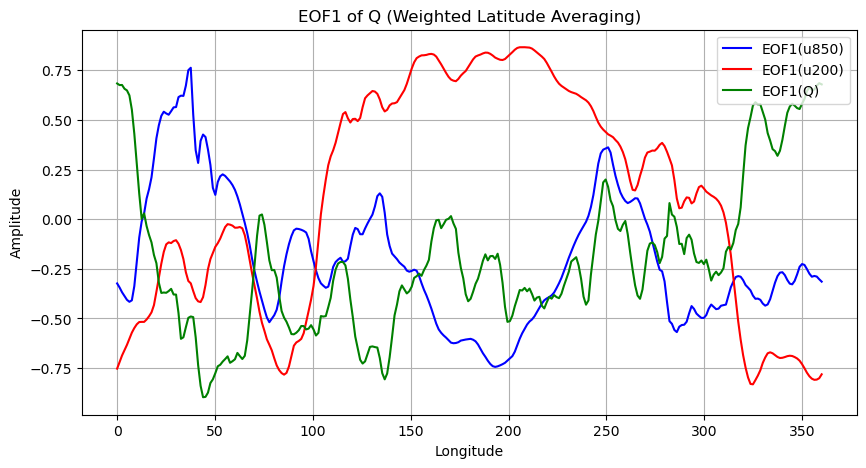

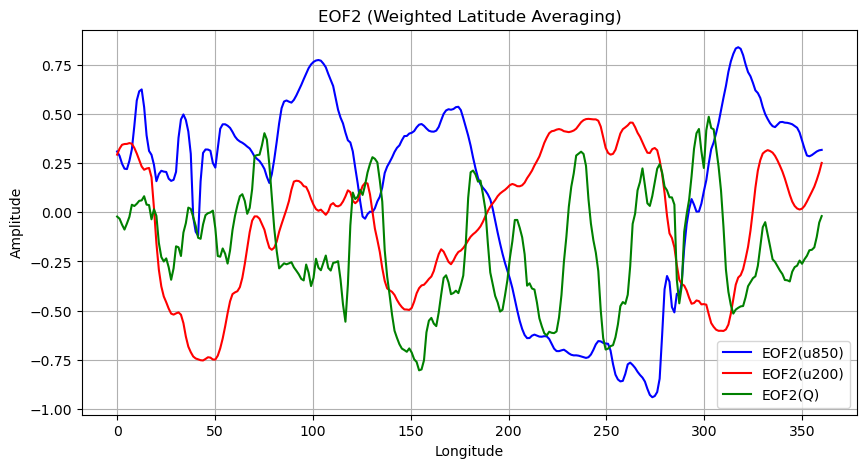

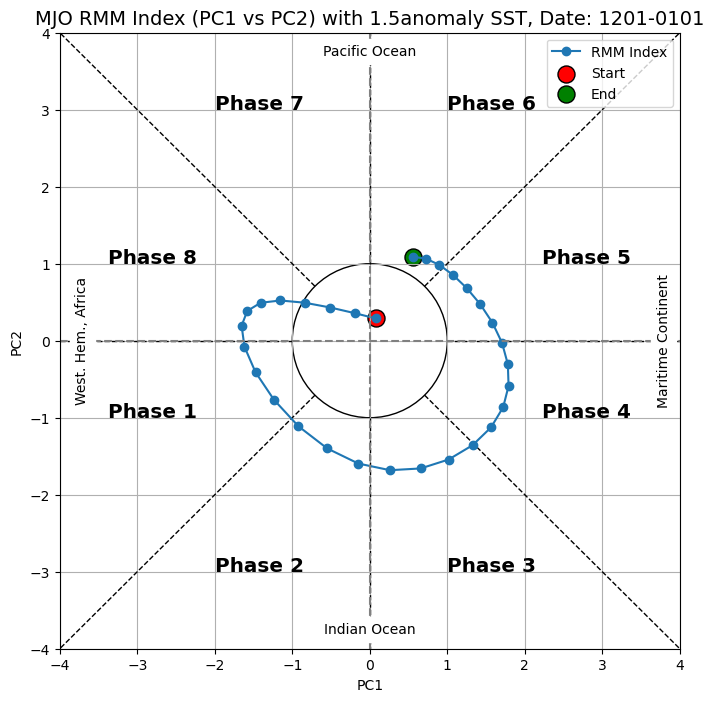

In [189]:
from EOF import EOF
# Step 1: Load Data
with Dataset("f09.F2000_MJO_1.5anomaly.cam.h0.1101_0201.nc", "r") as f:
    # print(f.variables.keys())
    u850 = f["U850"][:]
    v850 = f["V850"][:]
    precl = f["PRECL"][:]
    u200 = f["U200"][:]
    Q = f["FLNT"][:] 
    lat = f["lat"][:]
    time = f["time"][:]

# Step 2: Select latitude range (-15 to 15)
lat_mask = (lat >= -15) & (lat <= 15)
print("Selected latitude indices:", np.where(lat_mask)[0])

# Subset the data for the selected latitudes
u850 = u850[:, lat_mask, :]
v850 = v850[:, lat_mask, :]
precl = precl[:, lat_mask, :]
u200 = u200[:, lat_mask, :]
Q = Q[:, lat_mask, :]
print("Shape after latitude selection (u850):", u850.shape)


# Step 3: Column integrated Q (mean over levels)
# q_int = np.mean(Q, axis=1)  # Direct mean over vertical levels
q_int = Q
print("Integrated Q shape:", q_int.shape)

# Step 4: Latitude averaging with weighting
def latitude_weighted_average(data, lat):
    """
    Perform latitude-weighted averaging to obtain zonal mean.
    """
    # Calculate the weights
    weights = np.sqrt(np.cos(np.deg2rad(lat)))
    weights /= weights.sum()  # Normalize weights

    # Apply the weights to the data (broadcasting the weights along latitude)
    weighted_data = data * weights[:, np.newaxis]
    # Sum over latitude with weights applied
    return np.sum(weighted_data, axis=1)


# Apply latitude-weighted averaging to each variable
u850 = latitude_weighted_average(u850, lat[lat_mask])
v850 = latitude_weighted_average(v850, lat[lat_mask])
precl = latitude_weighted_average(precl, lat[lat_mask])
u200 = latitude_weighted_average(u200, lat[lat_mask])
q_int = latitude_weighted_average(q_int, lat[lat_mask])
print("Shape after latitude-weighted averaging (u850):", u850.shape)

# Step 5: Remove seasonal cycle with bandpass
from scipy.signal import filtfilt, butter

def band_pass_filter(data, lowcut=1/60, highcut=1/14, fs=1):
    """
    Band-pass filter to isolate MJO signals (14~60 days).
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(2, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

# Apply band-pass filter to isolate MJO signal
u850 = band_pass_filter(u850, lowcut=1/60, highcut=1/14)
u200 = band_pass_filter(u200, lowcut=1/60, highcut=1/14)
q_int = band_pass_filter(q_int, lowcut=1/60, highcut=1/14)
v850 = band_pass_filter(v850, lowcut=1/60, highcut=1/14)
precl = band_pass_filter(precl, lowcut=1/60, highcut=1/14)

print("Filtered shape (u850):", u850.shape)

# Step 6: Preprocess Data (remove overall mean and normalize)
def preprocess(data):
    data_anom = data - np.mean(data, axis=0) # anamoly to time
    data_std = np.std(data_anom, axis=0)
    # data_std[data_std == 0] = 1
    data_norm = data_anom / data_std
    return data_norm

# Preprocess each variable
u850_norm = preprocess(u850)
v850_norm = preprocess(v850)
u200_norm = preprocess(u200)
q_int_norm = preprocess(q_int)


# Step 7: Flatten and combine variables
time_dim, lon_dim = u850.shape
u850_flat = u850_norm.reshape(time_dim, lon_dim)
v850_flat = v850_norm.reshape(time_dim, lon_dim)

u200_flat = u200_norm.reshape(time_dim, lon_dim)
q_int_flat = q_int_norm.reshape(time_dim, lon_dim)

# combined = np.hstack((u850_flat, u200_flat, q_int_flat))
### FIXED! should use concatenate not hstack
# Concatenate in the correct order (variables are grouped, not mixed)
combined = np.concatenate((u850_flat, u200_flat, q_int_flat), axis=1) # (time, lon)
print("Combined shape after preprocessing:", combined.shape)

# Step 8: Calculate EOF and PC with latitude weighting
def Cal_EOF_PC(input_data):
    """
    Calculate EOF and PC from input data.
    """
    # Initialize an EOF instance
    n_component = min(input_data.shape[0], input_data.size // input_data.shape[0])
    print("n_component:", n_component)
    eof_instance = EOF((input_data,), n_components=n_component, field="1D")
    eof_instance.get()

    # Extract EOFs and PCs
    EOF1, EOF2, EOF3 = eof_instance.EOF[:3]
    PC1, PC2, PC3 = eof_instance.PC[:3]

    # Normalize PCs
    PC1_norm = (PC1 - PC1.mean()) / PC1.std()
    PC2_norm = (PC2 - PC2.mean()) / PC2.std()
    PC3_norm = (PC3 - PC3.mean()) / PC3.std()
    

    # EOFs with units 
    EOF1_norm = EOF1 * PC1.std() # (EOF1 - EOF1.mean()) / EOF1.std()
    EOF2_norm = EOF2 * PC2.std() # (EOF2 - EOF2.mean()) / EOF2.std()
    EOF3_norm = EOF3 * PC3.std() # (EOF2 - EOF2.mean()) / EOF2.std()
    
    return PC1_norm, PC2_norm, PC3_norm, EOF1_norm, EOF2_norm, EOF3_norm, eof_instance.explained[:10]


PC1, PC2, PC3, EOF1, EOF2, EOF3, explain = Cal_EOF_PC(combined)

# Step 9: Plot EOF1s
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0,360,288),EOF1[:288], label='EOF1(u850)', color='blue')
plt.plot(np.linspace(0,360,288),EOF1[288:288*2], label='EOF1(u200)', color='Red')
plt.plot(np.linspace(0,360,288),EOF1[288*2:288*3], label='EOF1(Q)', color='Green')


plt.title('EOF1 of Q (Weighted Latitude Averaging)')
plt.xlabel('Longitude')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

# Step 9: Plot EOF1 of Q
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0,360,288),EOF2[:288], label='EOF2(u850)', color='blue')
plt.plot(np.linspace(0,360,288),EOF2[288:288*2], label='EOF2(u200)', color='Red')
plt.plot(np.linspace(0,360,288),EOF2[288*2:288*3], label='EOF2(Q)', color='Green')


plt.title('EOF2 (Weighted Latitude Averaging)')
plt.xlabel('Longitude')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()


# Step 10: Plot RMM Index (PC1 vs PC2)
# 用固定半徑與角度生成一圈
theta = np.linspace(0, 2 * np.pi, 30)
radius = 0.85  # 固定 amplitude，可自由調整

PC1_demo = radius * np.cos(theta)  # RMM1
PC2_demo = radius * np.sin(theta)  # RMM2


start = 30
end   = 60
fig, ax = plot_mjo_phase_space(figsize=(8,8))
ax.plot(PC1[start:end], PC2[start:end], marker='o', linestyle='-', label='RMM Index')
# ax.plot(PC1_demo[17:], PC2_demo[17:], marker='o', linestyle='-', color="Blue", label='RMM Index')
# ax.plot(PC1_demo[:13], PC2_demo[:13], marker='o', linestyle='-', color="Blue")
# ax.scatter(PC1_demo[17], PC2_demo[17], color='red', edgecolors='black', s=150, label='Start')
# ax.scatter(PC1_demo[int(13-1)], PC2_demo[int(13-1)], color='green', edgecolors='black', s=150, label='End')



ax.scatter(PC1[start], PC2[start], color='red', edgecolors='black', s=150, label='Start')
ax.scatter(PC1[int(end-1)], PC2[int(end-1)], color='green', edgecolors='black', s=150, label='End')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('MJO RMM Index (PC1 vs PC2) with 1.5anomaly SST, Date: 1201-0101', fontsize=14)
ax.axhline(0, color='gray', linestyle='--')
ax.axvline(0, color='gray', linestyle='--')
ax.grid(True)
ax.legend()
plt.show()

In [162]:
np.ones(30).shape

(30,)

-4.476705744456276e-19
-2.9844704963041845e-19
1.0
0.9999999999999998


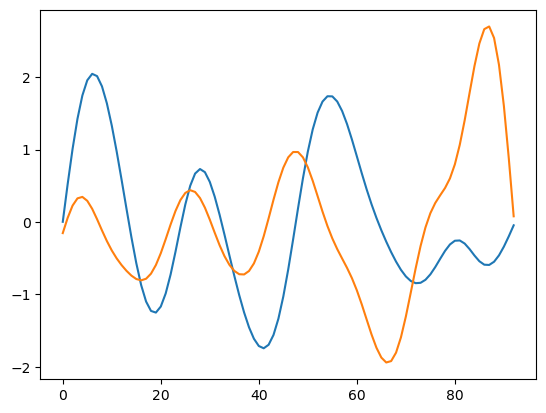

In [163]:
plt.figure()
plt.plot(PC1)
plt.plot(PC2)
print(PC1.mean())
print(PC2.mean())

print(PC1.std())
print(PC2.std())

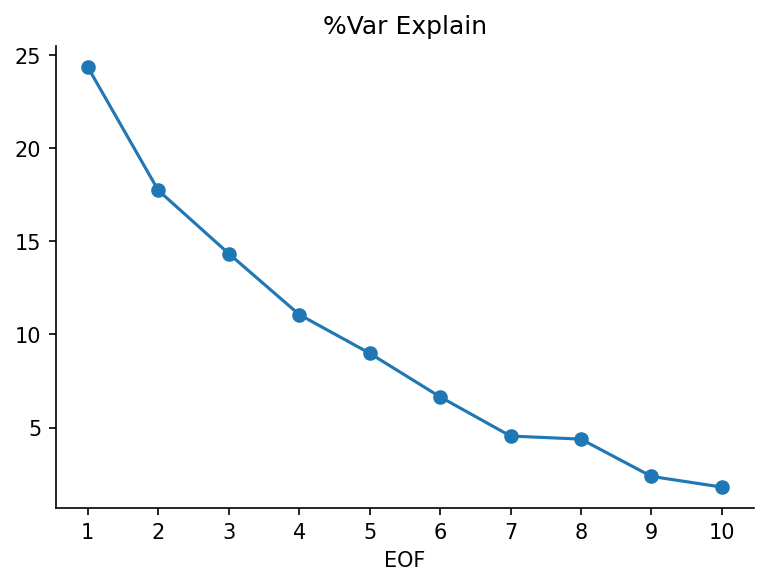

In [153]:
fig, ax = plt.subplots(1, figsize=(6,4), dpi=150)
ax.plot(np.arange(1,11,1), explain * 100, '-o')
ax.set_title("%Var Explain")
ax.set_xlabel("EOF")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks(np.arange(1, 11, 1))  
plt.show()


In [190]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy.signal import filtfilt, butter
from EOF import EOF

class MJO_EOF_Analyzer:
    def __init__(self, filename):
        self.filename = filename
        self._load_data()
        self._select_latitude_range()
        self._latitude_weighted_average()
        self._band_pass_filter()
        self._preprocess()
        self._combine_and_compute_eof()

    def _load_data(self):
        with Dataset(self.filename, "r") as f:
            self.u850 = f["U850"][:]
            self.v850 = f["V850"][:]
            self.precl = f["PRECL"][:]
            self.u200 = f["U200"][:]
            self.Q = f["FLNT"][:] 
            self.lat = f["lat"][:]
            self.time = f["time"][:]
    
    def _select_latitude_range(self):
        lat_mask = (self.lat >= -15) & (self.lat <= 15)
        self.lat_mask = lat_mask
        self.lat_selected = self.lat[lat_mask]
        self.u850 = self.u850[:, lat_mask, :]
        self.v850 = self.v850[:, lat_mask, :]
        self.precl = self.precl[:, lat_mask, :]
        self.u200 = self.u200[:, lat_mask, :]
        self.Q = self.Q[:, lat_mask, :]

    def _latitude_weighted_average(self):
        def lat_weighted(data, lat):
            weights = np.sqrt(np.cos(np.deg2rad(lat)))
            weights /= weights.sum()
            return np.sum(data * weights[:, np.newaxis], axis=1)

        self.u850 = lat_weighted(self.u850, self.lat_selected)
        self.v850 = lat_weighted(self.v850, self.lat_selected)
        self.u200 = lat_weighted(self.u200, self.lat_selected)
        self.precl = lat_weighted(self.precl, self.lat_selected)
        self.q_int = lat_weighted(self.Q, self.lat_selected)

    def _band_pass_filter(self, lowcut=1/60, highcut=1/14, fs=1):
        def bandpass(data):
            nyquist = 0.5 * fs
            b, a = butter(2, [lowcut/nyquist, highcut/nyquist], btype='band')
            return filtfilt(b, a, data, axis=0)

        self.u850 = bandpass(self.u850)
        self.v850 = bandpass(self.v850)
        self.u200 = bandpass(self.u200)
        self.precl = bandpass(self.precl)
        self.q_int = bandpass(self.q_int)

    def _preprocess(self):
        def standardize(data):
            anomaly = data - np.mean(data, axis=0)
            return anomaly / np.std(anomaly, axis=0)

        self.u850 = standardize(self.u850)
        self.v850 = standardize(self.v850)
        self.u200 = standardize(self.u200)
        self.q_int = standardize(self.q_int)

    def _combine_and_compute_eof(self):
        time_dim, lon_dim = self.u850.shape
        flat_u850 = self.u850.reshape(time_dim, lon_dim)
        flat_u200 = self.u200.reshape(time_dim, lon_dim)
        flat_qint = self.q_int.reshape(time_dim, lon_dim)
        combined = np.concatenate((flat_u850, flat_u200, flat_qint), axis=1)

        eof_instance = EOF((combined,), n_components=3, field="1D")
        eof_instance.get()
        PC1 = eof_instance.PC[0]
        PC2 = eof_instance.PC[1]

        # Normalize PCs
        self.PC1 = (PC1 - PC1.mean()) / PC1.std()
        self.PC2 = (PC2 - PC2.mean()) / PC2.std()
        self.explained = eof_instance.explained[:3]

    def get_pc1_pc2(self):
        return self.PC1, self.PC2


In [193]:
def plot_mjo_phase_space_ax(ax):
    import numpy as np
    import matplotlib.lines as lines

    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_xticks(range(-4, 5))
    ax.set_yticks(range(-4, 5))

    # plot MJO phase diagram lines
    ax.add_line(lines.Line2D([np.cos(np.pi/4), 4], [np.sin(np.pi/4), 4], color='black', linestyle='--', lw=1))
    ax.add_line(lines.Line2D([np.cos(3*np.pi/4), -4], [np.sin(np.pi/4), 4], color='black', linestyle='--', lw=1))
    ax.add_line(lines.Line2D([np.cos(np.pi/4), 4], [np.sin(7*np.pi/4), -4], color='black', linestyle='--', lw=1))
    ax.add_line(lines.Line2D([np.cos(3*np.pi/4), -4], [np.sin(7*np.pi/4), -4], color='black', linestyle='--', lw=1))
    ax.add_line(lines.Line2D([-4, -1], [0, 0], color='black', linestyle='--', lw=1))
    ax.add_line(lines.Line2D([1, 4], [0, 0], color='black', linestyle='--', lw=1))
    ax.add_line(lines.Line2D([0, 0], [1, 4], color='black', linestyle='--', lw=1))
    ax.add_line(lines.Line2D([0, 0], [-1, -4], color='black', linestyle='--', lw=1))

    amp1_circ = plt.Circle((0, 0), 1, color='black', fill=False)
    ax.add_patch(amp1_circ)

    # add phase diagram texts
    ax.text(1, 3, 'Phase 6', size='medium', weight='semibold')
    ax.text(-2, 3, 'Phase 7', size='medium', weight='semibold')
    ax.text(2.8, 1, 'Phase 5', size='medium', weight='semibold', ha='center')
    ax.text(-2.8, 1, 'Phase 8', size='medium', weight='semibold', ha='center')
    ax.text(1, -3, 'Phase 3', size='medium', weight='semibold')
    ax.text(-2, -3, 'Phase 2', size='medium', weight='semibold')
    ax.text(2.8, -1, 'Phase 4', size='medium', weight='semibold', ha='center')
    ax.text(-2.8, -1, 'Phase 1', size='medium', weight='semibold', ha='center')

    ax.text(0, 3.7, 'Pacific Ocean', ha='center', bbox=dict(facecolor='white', edgecolor='white'))
    ax.text(0, -3.8, 'Indian Ocean', ha='center', bbox=dict(facecolor='white', edgecolor='white'))
    ax.text(-3.8, 0, 'West. Hem., Africa', va='center', rotation='vertical', bbox=dict(facecolor='white', edgecolor='white'))
    ax.text(3.7, 0, 'Maritime Continent', va='center', rotation='vertical', bbox=dict(facecolor='white', edgecolor='white'))

    ax.set_xlabel('RMM1')
    ax.set_ylabel('RMM2')
    ax.grid(True)


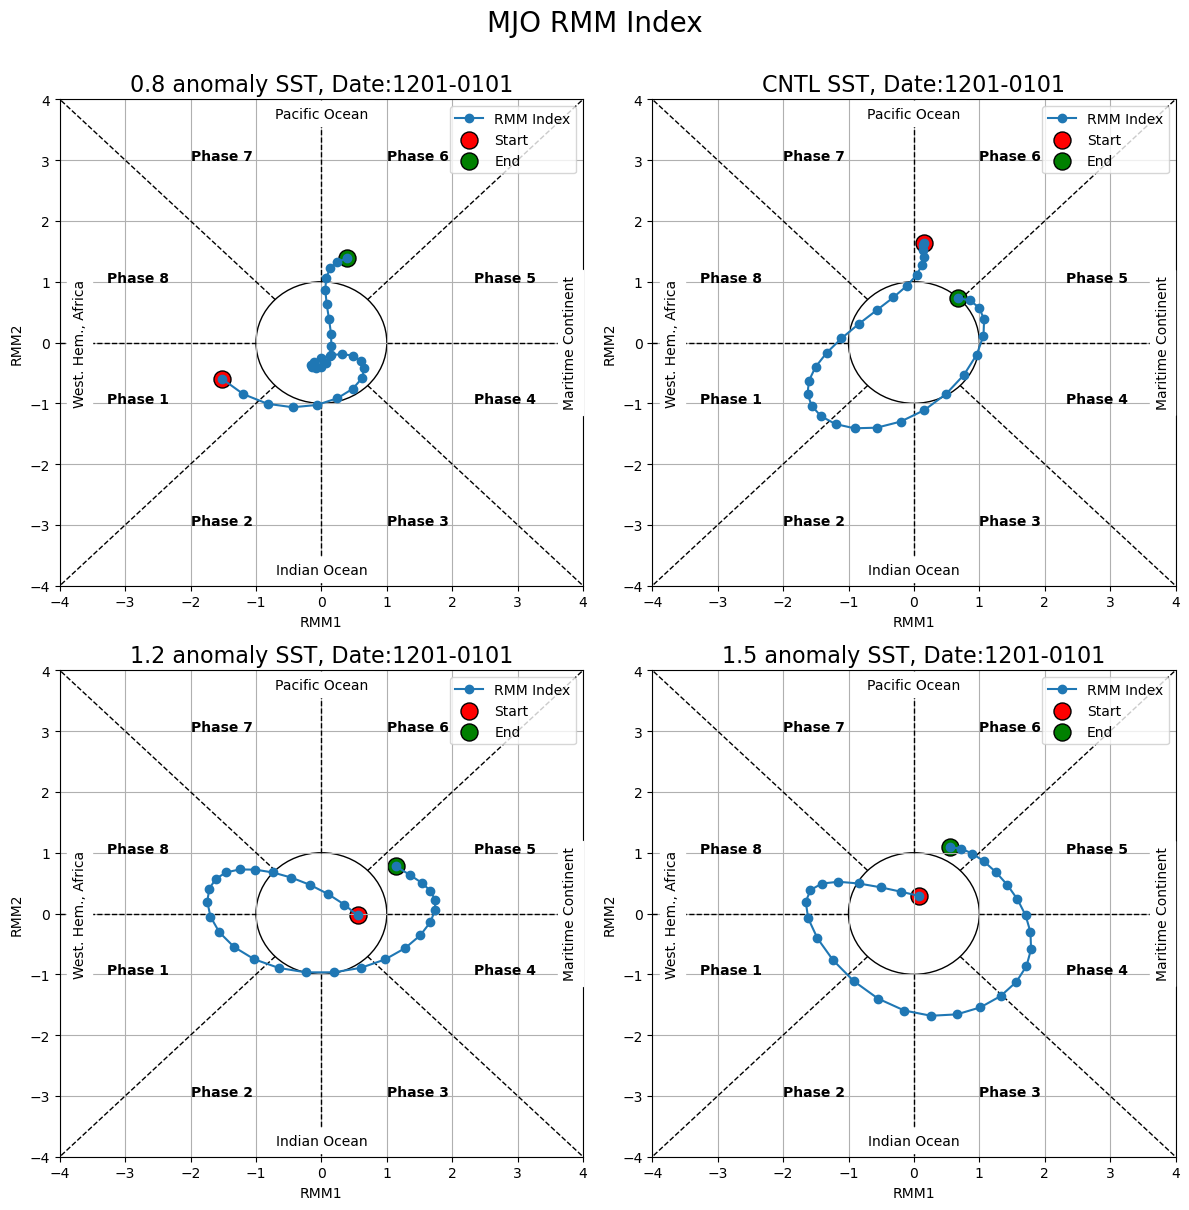

In [235]:
files = [
    "f09.F2000_MJO_0.8anomaly.cam.h0.1101_0201.nc",
    "f09.F2000_MJO_control.cam.h0.1101_0201.nc",
    "f09.F2000_MJO_1.2anomaly.cam.h0.1101_0201.nc",
    "f09.F2000_MJO_1.5anomaly.cam.h0.1101_0201.nc"
]

titles = ["0.8 anomaly", "CNTL", "1.2 anomaly", "1.5 anomaly"]
pcs = []

# 跑四個實驗
for f in files:
    analyzer = MJO_EOF_Analyzer(f)
    pcs.append(analyzer.get_pc1_pc2())
    
start = 30
end = 60

fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # 2 rows, 2 columns
axs = axs.flat  # flatten to 1D array for easier looping

for i, ax in enumerate(axs):
    PC1, PC2 = pcs[i]
    if i ==0:
        PC1, PC2 = PC1, -PC2
    elif i == 2:
        PC1, PC2 = PC1, -PC2
        
        
    plot_mjo_phase_space_ax(ax)  # 畫 RMM 背景圖
    
    ax.plot(PC1[start:end], PC2[start:end], marker='o', linestyle='-', label='RMM Index')
    ax.scatter(PC1[start], PC2[start], color='red', edgecolors='black', s=150, label='Start')
    ax.scatter(PC1[end-1], PC2[end-1], color='green', edgecolors='black', s=150, label='End')
    
    ax.set_title(f"{titles[i]} SST, Date:1201-0101", fontsize=16)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.legend(fontsize=10)

plt.suptitle("MJO RMM Index", fontsize=20, y=1.005)
plt.tight_layout()
plt.savefig("/data92/PeterChang/ESM_2025/Figures/result.png", dpi=300., bbox_inches='tight')
plt.show()
